In [0]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [0]:
plt.rcParams["figure.figsize"] = (6,6)

In [0]:
import numpy as np
import pandas as pd

In [0]:
import tqdm
import pathlib
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random as rn


TensorFlow 2.x selected.


In [0]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

In [0]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,0.8])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,0.8])
  plt.legend()
  plt.show()

In [0]:
train_target = pd.read_csv('https://sibur.ai-community.com/files/uploads/ea60e971b41e70fece6f266e68a41488/rubber_target_train.csv', index_col="date", parse_dates=["date"],dtype=np.float32)
test_target = pd.read_csv('https://sibur.ai-community.com/files/uploads/c0b27f1fc0ad165fc6c30cd3c7214468/rubber_test_timestamps.csv', index_col="date", parse_dates=["date"],dtype=np.float32)
data = pd.read_csv('https://sibur.ai-community.com/files/uploads/bc4f721232fc48f676f524bd707bdc00/rubber_daily.csv', index_col="date", parse_dates=["date"],dtype=np.float32)

Text(0.5, 1, 'Rubber prices')

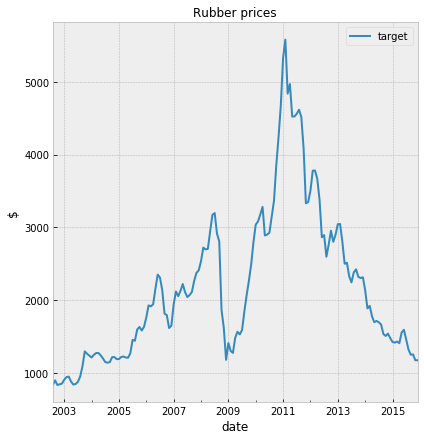

In [183]:
train_target["rubber"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

In [462]:
data

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.639999,25.500000,25.719999,25.389999,8.2770,8.2770,8.2770,8.2770,41.570000,41.570000,41.395000,41.500000,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.750000,25.610001,25.969999,25.600000,8.2769,8.2769,8.2769,8.2769,41.514999,41.560001,41.419998,41.540001,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.840000,25.730000,25.959999,25.520000,8.2768,8.2768,8.2768,8.2768,41.610001,41.645000,41.520000,41.529999,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.549999,25.879999,25.940001,25.500000,8.2767,8.2767,8.2767,8.2767,41.544998,41.619999,41.494999,41.500000,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.730000,25.650000,25.750000,25.420000,8.2766,8.2766,8.2766,8.2766,41.645000,41.639999,41.514999,41.560001,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.860001,65.500000,65.790001,64.080002,6.8770,6.8736,6.8873,6.8700,30.665001,30.820000,30.650000,30.809999,14140.0,14170.0,14130.0,14130.0,23291.0,23300.0,23280.0,23290.0,1469.0
2019-06-25,65.050003,64.889999,65.980003,64.169998,6.8798,6.8715,6.8851,6.8655,30.709999,30.750000,30.620001,30.660000,14125.0,14140.0,14090.0,14135.0,23297.0,23305.0,23284.0,23290.0,1495.0
2019-06-26,66.489998,65.800003,66.849998,65.599998,6.8800,6.8876,6.8937,6.8658,30.735001,30.870001,30.700001,30.760000,14175.0,14180.0,14130.0,14130.0,23305.0,23320.0,23287.0,23300.0,1498.0


In [562]:
fts = data.resample("D").mean()

COLS = [col for col in fts.columns if ("USDVND_max" not in col
                                        and "USDVND_min" not in col
                                        and "USDVND_open" not in col)]
fts = fts[COLS].ffill()
fts.isna().sum().sort_values(ascending=False).head(5)

rubber_close    0
USDVND_mid      0
brent_open      0
brent_max       0
brent_min       0
dtype: int64

In [547]:
fts

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close
date,,,,,,,,,,,,,,,,,,
2002-07-01,25.639999,25.500000,25.719999,25.389999,8.2770,8.2770,8.2770,8.2770,41.570000,41.570000,41.395000,41.500000,8710.0,8715.0,8669.0,8700.0,15297.5,835.0
2002-07-02,25.750000,25.610001,25.969999,25.600000,8.2769,8.2769,8.2769,8.2769,41.514999,41.560001,41.419998,41.540001,8805.0,8820.0,8720.0,8720.0,15297.0,827.5
2002-07-03,25.840000,25.730000,25.959999,25.520000,8.2768,8.2768,8.2768,8.2768,41.610001,41.645000,41.520000,41.529999,8965.0,8985.0,8790.0,8825.0,15297.5,847.5
2002-07-04,25.549999,25.879999,25.940001,25.500000,8.2767,8.2767,8.2767,8.2767,41.544998,41.619999,41.494999,41.500000,8855.0,8970.0,8790.0,8790.0,15298.5,847.5
2002-07-05,25.730000,25.650000,25.750000,25.420000,8.2766,8.2766,8.2766,8.2766,41.645000,41.639999,41.514999,41.560001,8860.0,8850.0,8815.0,8830.0,15295.0,847.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.860001,65.500000,65.790001,64.080002,6.8770,6.8736,6.8873,6.8700,30.665001,30.820000,30.650000,30.809999,14140.0,14170.0,14130.0,14130.0,23291.0,1469.0
2019-06-25,65.050003,64.889999,65.980003,64.169998,6.8798,6.8715,6.8851,6.8655,30.709999,30.750000,30.620001,30.660000,14125.0,14140.0,14090.0,14135.0,23297.0,1495.0
2019-06-26,66.489998,65.800003,66.849998,65.599998,6.8800,6.8876,6.8937,6.8658,30.735001,30.870001,30.700001,30.760000,14175.0,14180.0,14130.0,14130.0,23305.0,1498.0


In [0]:
import requests
import io

BASE_URL = "https://www.ncei.noaa.gov/access/services/data/v1"

STATIONS = ["IDM00096087", "VMM00048914", "TH000048426"]
STATIONS_QUERY = f'stations={",".join(STATIONS)}'

DATA_TYPES = ["TAVG", "TMAX", "TMIN", "PRCP"]
DATA_TYPES_QUERY = f'dataTypes={",".join(DATA_TYPES)}'

START = "2002-01-01"
END = "2019-08-01"

BASE_PARAMS = ["units=metric",
               "dataset=daily-summaries",
               f"startDate={START}",
               f"endDate={END}",               
               STATIONS_QUERY,
               DATA_TYPES_QUERY]

response = requests.get("?".join([BASE_URL, "&".join(BASE_PARAMS)]))

assert response.status_code==200

weather_data = pd.read_csv(io.StringIO(response.text), parse_dates=["DATE"])

weather_data.groupby("STATION").count()

weather_data.fillna({"PRCP":0}, inplace=True)
weather_data.ffill(inplace=True)

pd.date_range(START, END, freq="1D")

full_weather_data = []

for station, station_data in weather_data.groupby("STATION"):
    full_weather_data.append(station_data
                     .set_index("DATE")
                     .drop("STATION", axis=1)
                     .rename(lambda cl: f"{cl}_{station}", axis=1))

full_weather_data = pd.concat(full_weather_data, axis=1)
full_weather_data = full_weather_data.reindex(pd.date_range(START, END, freq="1D"))

full_weather_data.drop([cl for cl in full_weather_data.columns if "PRCP" in cl], axis=1, inplace=True)
full_weather_data.ffill(inplace=True)

full_weather_data.head()

fts = fts.join(full_weather_data, how="inner")

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(fts)
t = pca.transform(fts)

cols = [f"f{i:d}" for i in range(t.shape[1])]
fts = pd.DataFrame(t, index=fts.index, columns=cols)

fts.head()

In [564]:
rolling_features = fts.rolling("30D").aggregate("mean")
all_features = rolling_features[rolling_features.index.day==9]

all_features["prediction_date"] = (all_features.index
                                   + pd.TimedeltaIndex(all_features.index.days_in_month-8,
                                                       unit="D"));

all_features.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close,prediction_date
date,,,,,,,,,,,,,,,,,,,
2002-07-09,25.580000,25.607778,25.754444,25.331111,8.276722,8.276722,8.276722,8.276722,41.540000,41.590555,41.437222,41.523334,8858.333333,8877.222222,8786.555556,8810.333333,15296.333333,840.833333,2002-08-01
2002-08-09,25.602000,25.531333,25.818667,25.259666,8.276800,8.276800,8.276800,8.276800,41.483667,41.594666,41.187400,41.360166,9032.316667,9101.500000,8911.000000,9013.166667,15311.300000,801.000000,2002-09-01
2002-09-09,27.152000,27.030667,27.414334,26.826334,8.276810,8.276810,8.276810,8.276810,42.150667,42.226500,42.047333,42.129334,8860.833333,8890.600000,8824.266667,8861.500000,15328.050000,864.083333,2002-10-01
2002-10-09,28.486333,28.518667,28.815000,28.218000,8.277060,8.277060,8.277060,8.277060,43.257667,43.297500,43.078000,43.150333,9003.050000,9008.200000,8973.333333,8988.533333,15340.766667,871.916667,2002-11-01
2002-11-09,26.184000,26.386000,26.649334,25.999667,8.276967,8.276967,8.276967,8.276967,43.527000,43.604000,43.439000,43.535000,9201.600000,9219.100000,9133.400000,9177.200000,15360.466667,829.583333,2002-12-01


In [565]:
final_fts = all_features.ffill()
final_fts.isna().sum().sort_values(ascending=False).head(5)

prediction_date    0
USDTHB_mid         0
brent_open         0
brent_max          0
brent_min          0
dtype: int64

In [566]:
df = train_target.join(final_fts.set_index("prediction_date"), how="outer")
df.index.name = "date"
df.head()

,rubber,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close
date,,,,,,,,,,,,,,,,,,,
2002-08-01,830.595215,25.580000,25.607778,25.754444,25.331111,8.276722,8.276722,8.276722,8.276722,41.540000,41.590555,41.437222,41.523334,8858.333333,8877.222222,8786.555556,8810.333333,15296.333333,840.833333
2002-09-01,895.476196,25.602000,25.531333,25.818667,25.259666,8.276800,8.276800,8.276800,8.276800,41.483667,41.594666,41.187400,41.360166,9032.316667,9101.500000,8911.000000,9013.166667,15311.300000,801.000000
2002-10-01,831.304321,27.152000,27.030667,27.414334,26.826334,8.276810,8.276810,8.276810,8.276810,42.150667,42.226500,42.047333,42.129334,8860.833333,8890.600000,8824.266667,8861.500000,15328.050000,864.083333
2002-11-01,840.250000,28.486333,28.518667,28.815000,28.218000,8.277060,8.277060,8.277060,8.277060,43.257667,43.297500,43.078000,43.150333,9003.050000,9008.200000,8973.333333,8988.533333,15340.766667,871.916667
2002-12-01,849.875000,26.184000,26.386000,26.649334,25.999667,8.276967,8.276967,8.276967,8.276967,43.527000,43.604000,43.439000,43.535000,9201.600000,9219.100000,9133.400000,9177.200000,15360.466667,829.583333


In [0]:
df["month"] = df.index.month
FCOLS = df.columns[1:]
TARGET = "rubber"

In [0]:
tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

Text(0.5, 1, 'Rubber prices')

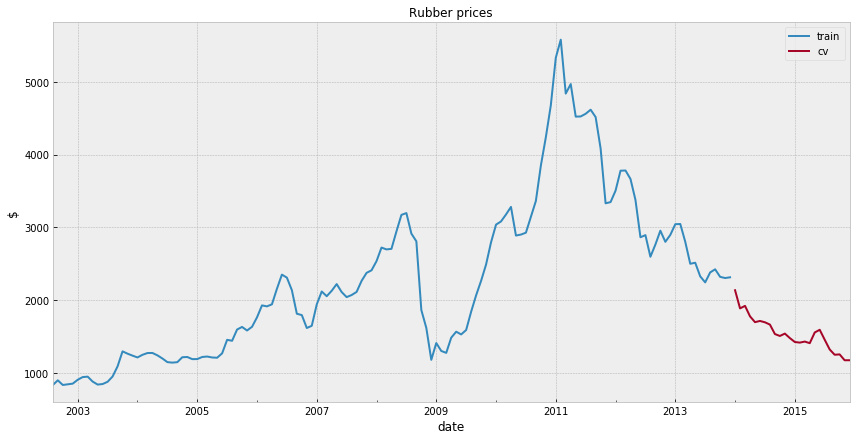

In [569]:
tr[TARGET].plot(ax=plt.gca(), label="train")
cv[TARGET].plot(ax=plt.gca(), label="cv")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

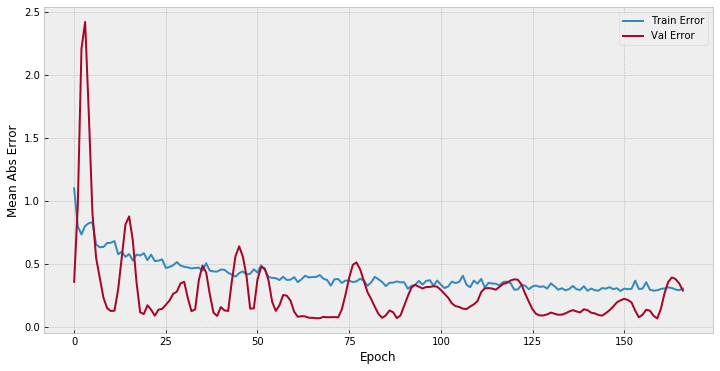

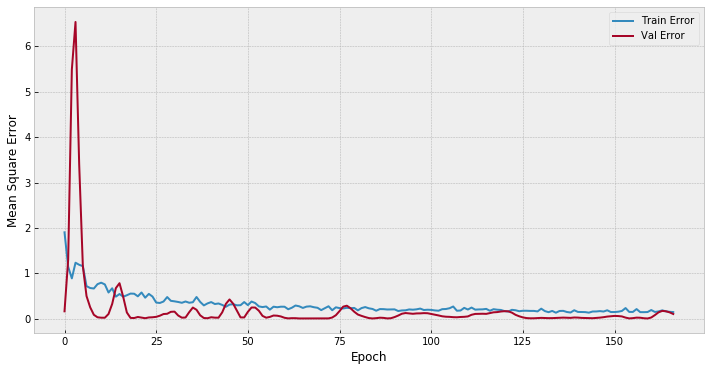

MAPE (training set): 10.79%
MAPE (cross-validation set): 5.04%


In [570]:
RS=77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

tf.keras.backend.clear_session()

EPOCHS = 500
BS = 128

tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

center, scale = tr[FCOLS].mean().values, tr[FCOLS].std().values
trn = (tr[FCOLS] - center)/scale
cvn = (cv[FCOLS] - center)/scale

y_trn = tr[TARGET].values
y_cv =  cv[TARGET].values

model = keras.Sequential([
  layers.Input(shape=(len(FCOLS))),
  layers.Dense(128),
  layers.Dropout(0.3),
  layers.Dense(64),
  layers.Dropout(0.2),
  layers.Dense(16),
  layers.Dropout(0.1),
  layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer='adam', metrics=['mae', 'mse'], loss='mse') #tf.keras.losses.Huber())
model.summary()
model.reset_states()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1)

'''
lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.9)
tf.compat.v1.train.cosine_decay(1e-3, epoch, epoch // 10, 0.2)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(step_decay) #lambda epoch: 1e-7 * 10**(epoch / 20))
'''
history = model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=0,
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
            #lr_schedule,
            keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])  
model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

plot_history(history)

tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr[TARGET].index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv[TARGET].index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(y_trn, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(y_cv, cv_preds.values):.2f}%")


In [0]:
'''
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1, 0, 2])
'''

Визуализируем предсказания:

TR performance: 10.8%
CV performance: 5.0%


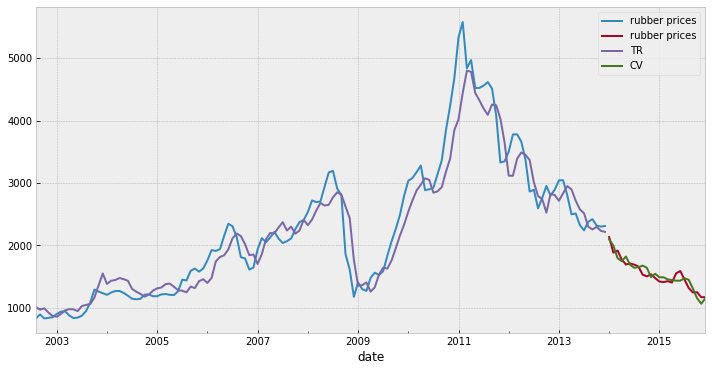

In [571]:
print(f"TR performance: {100 * mape(tr[TARGET], tr_preds):0.1f}%")
print(f"CV performance: {100 * mape(cv[TARGET], cv_preds):0.1f}%")

plt.figure();
tr[TARGET].plot(ax=plt.gca(), label="rubber prices");
cv[TARGET].plot(ax=plt.gca(), label="rubber prices");
tr_preds.plot(ax=plt.gca(), label="TR");
cv_preds.plot(ax=plt.gca(), label="CV");
plt.legend(loc=0);


Считаем предсказания для тестового набора:

In [425]:
tst = (df[FCOLS] - center)/scale

ts_preds = model.predict(tst, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
ts_preds = pd.DataFrame(ts_preds, columns=["rubber"], index=df.index)
ts_preds.loc[test_target.index].to_csv("rubber_NN.csv")

Визуализируем весь таймфрейм:

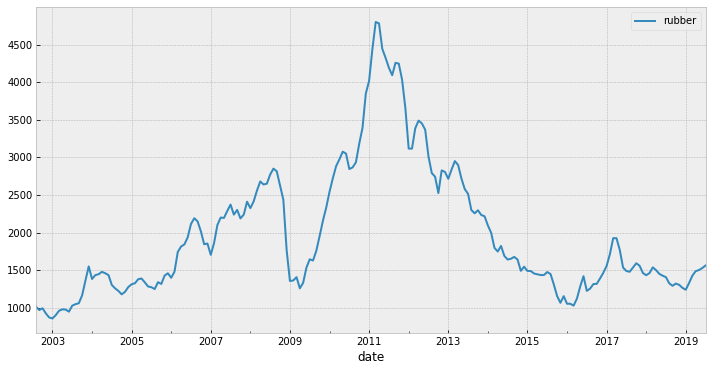

In [572]:
tst = (df[FCOLS] - center)/scale

ts_preds = model.predict(tst, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
ts_preds = pd.DataFrame(ts_preds, columns=["rubber"], index=df.index)

plt.rcParams["figure.figsize"] = (12,6)
ts_preds.plot();